In [189]:
import pandas as pd
import json
import os

import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from collections import deque, defaultdict, Counter
import uuid

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics.pairwise import chi2_kernel

%matplotlib inline

In [3]:
DATA_PATH = os.path.expanduser("~/data")

In [4]:
with open("{}/ast-tree-6g.jsonl".format(DATA_PATH)) as f:
    raw = (entry.split("\t") for entry in f.readlines())
    labels = []
    features = []
    for label, ast in raw:
        labels.append(int(label))
        features.append( Counter(json.loads(ast)) )

In [8]:
n = len(labels)
Y = np.array(labels)

In [89]:
indices = np.random.permutation(n)
itrain, idev, itest = indices[3000:], indices[:1500], indices[1500:3000]

In [90]:
all_types = Counter()
for f in features:
    for k in f.keys():
        all_types[k] += 1

In [91]:
def map_common_indices(counter, n):
    mapping = {}
    for i, (key, _) in enumerate(counter.most_common(n)):
        mapping[key] = i
    return mapping

In [92]:
dims = range(100, len(all_types), 100)

In [95]:
def tune(dimension):
    mapping = map_common_indices(all_types, dimension)
    X0 = np.zeros(dtype='int32', shape=[n, len(mapping)])
    # count features
    for i, f in enumerate(features):
        for k,v in f.iteritems():
            if k in mapping:
                X0[i, mapping[k]] = v
    # distance matrix
    X = np.zeros(dtype='float32', shape=[n, n])

    for i in xrange(n):
        for j in xrange(i, n):
            m = np.sum( np.abs(X0[i] - X0[j]) )
            X[i, j] = m
            X[j, i] = m
    # model
    mat = np.log(X+1.0)
    sims = 1 - mat/np.max(mat)

    x_train, x_dev = sims[itrain][:,itrain], sims[idev][:,itrain]
    y_train, y_dev = Y[itrain], Y[idev]

    svm = SVC(kernel='precomputed', probability=True)
    # clf = AdaBoostClassifier(svm)
    svm.fit(x_train, y_train)
    return svm, svm.score(x_dev, y_dev), X

In [96]:
best_score = 0.0
X = None
model = None
scores = []
for d in dims:
    mod, score, dists = tune(d)
    scores.append(score)
    if score > best_score:
        model = mod
        X = dists
        best_score = score
        print "Dim={} Score: {}".format(d, score)
    else:
        print "No improvement"

Dim=100 Score: 0.849333333333
No improvement
No improvement
No improvement
Dim=500 Score: 0.85
Dim=600 Score: 0.850666666667
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement
No improvement


In [97]:
mat = np.log(X+1.0)
sims = 1 - mat/np.max(mat)
x_test = sims[itest][:,itrain]
y_test = Y[itest]
print "Score Test: {}".format(model.score(x_test, y_test))

Score Test: 0.84


In [151]:
def tf_transform(features, vocab_mapping):
    tf = np.zeros(dtype='float32', shape=[len(features), len(vocab_mapping)])
    for i, f in enumerate(features):
        for t, count in f.iteritems():
            if t in vocab_mapping:
                tf[i, vocab_mapping[t]] = np.log(count + 1)
    return tf

def idf_transform(features, vocab_mapping):
    idf = np.zeros(dtype='float32', shape=[len(vocab_mapping)])
    for t in vocab_mapping:
        nd = np.sum(1.0 if t in f else 0.0 for f in features)
        idf[vocab_mapping[t]] = nd
    return np.log(len(features) / idf)

In [152]:
best_mapping = map_common_indices(all_types, 600)
X_tf = tf_transform(features, best_mapping)
idf  = idf_transform(features, best_mapping)
X_tfidf = np.apply_along_axis(lambda r:r*idf, 1, X_tf)

x_train, x_dev, x_test = X_tfidf[itrain], X_tfidf[idev], X_tfidf[itest]
y_train, y_dev, y_test = Y[itrain], Y[idev], Y[itest]

In [160]:
base_logistic = SGDClassifier(loss='log', penalty='l2')
base_logistic.fit(x_train, y_train)
base_logistic.score(x_test, y_test)

0.77666666666666662

In [183]:
# logistic regression with L2 regularization
clf = AdaBoostClassifier(DecisionTreeClassifier(), 
                         # algorithm='SAMME',
                         n_estimators=100)
clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [184]:
print "Score Train : {}".format(clf.score(x_train, y_train))
print "Score Dev : {}".format(clf.score(x_dev, y_dev))
print "Score Test: {}".format(clf.score(x_test, y_test))

Score Train : 0.972529906956
Score Dev : 0.864666666667
Score Test: 0.861333333333


In [190]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [191]:
print "Score Train : {}".format(rf.score(x_train, y_train))
print "Score Dev : {}".format(rf.score(x_dev, y_dev))
print "Score Test: {}".format(rf.score(x_test, y_test))

Score Train : 0.972382218284
Score Dev : 0.872
Score Test: 0.868666666667


In [185]:
# logistic regression with L2 regularization
clf = AdaBoostClassifier(SGDClassifier(loss='log', penalty='l2'), 
                         algorithm='SAMME',
                         n_estimators=100)
clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=100, random_state=None)

In [186]:
print "Score Train : {}".format(clf.score(x_train, y_train))
print "Score Dev : {}".format(clf.score(x_dev, y_dev))
print "Score Test: {}".format(clf.score(x_test, y_test))

Score Train : 0.799586471718
Score Dev : 0.775333333333
Score Test: 0.786666666667


In [165]:
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000)
X2d = tsne.fit_transform(X_tfidf)

In [168]:
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000, metric='precomputed')
X2d_dist = tsne.fit_transform(X)

In [149]:
flag,  = np.where(Y==1.0)
no_flag, = np.where(Y!=1.0)

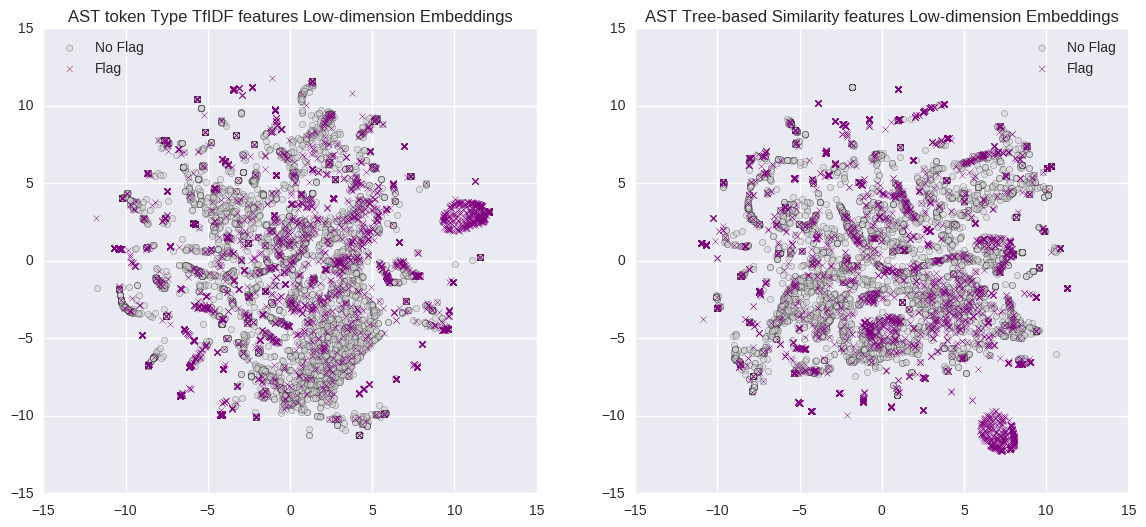

In [179]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax1.scatter(*X2d[no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=0.5)
ax1.scatter(*X2d[flag].T, c='purple', marker='x', label='Flag', alpha=1.0)
ax1.legend(loc='upper left')
ax1.set_title("AST token Type TfIDF features Low-dimension Embeddings")

ax2.scatter(*X2d_dist[no_flag].T, c='lightgrey', marker='o', label='No Flag', alpha=0.5)
ax2.scatter(*X2d_dist[flag].T, c='purple', marker='x', label='Flag', alpha=1.0)
ax2.legend(loc='upper right')
ax2.set_title("AST Tree-based Similarity features Low-dimension Embeddings")